In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CSV einlesen
df = pd.read_csv('../data/processed/germany_model_dataset.csv')

# Historische Daten für später
historical_data = df[df['Year'] <= 2017]
years_historical = historical_data['Year'].values
true_total = historical_data['CO2_total'].values

# Ursprüngliche Features
base_features = [
    'GDP', 'Population', 'Primary_energy', 'Energy_intensity',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual'
]

# Rolling Average anwenden
df[base_features] = df[base_features].rolling(window=3, min_periods=1).mean()

# Lags erzeugen (Lag 1 & 2 für ausgewählte Features)
lag_features = ['GDP', 'Energy_intensity']
for col in lag_features:
    for lag in [1, 2]:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# NaNs entfernen
df.dropna(inplace=True)

# Input-Features aktualisieren
input_features = base_features + [f"{col}_lag{lag}" for col in lag_features for lag in [1, 2]]

# Zielvariablen
target_columns = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']

# Daten bis 2017
df_model = df[df['Year'] <= 2017].copy()

# Skalierung
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df_model[input_features])
y_scaled = target_scaler.fit_transform(df_model[target_columns])

# Fenstergröße
window_size = 10
X_seq, y_seq = [], []
for i in range(len(X_scaled) - window_size):
    X_seq.append(X_scaled[i:i + window_size])
    y_seq.append(y_scaled[i + window_size])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train/Test Split (zeitlich korrekt)
n_train = df_model[df_model['Year'] <= 2005].shape[0]
X_train = X_seq[:n_train - window_size]
y_train = y_seq[:n_train - window_size]
X_test = X_seq[n_train - window_size:]
y_test = y_seq[n_train - window_size:]

# Modell
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(window_size, len(input_features))))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(units=len(target_columns)))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Vorhersage auf dem Testdatensatz (skaliert)
y_pred_scaled = model.predict(X_test)

# Rücktransformation in Originaleinheiten
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

# Rücktransformation in Originaleinheiten
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test)

# Fehler-Metriken pro Zielvariable (CO₂-Komponenten)
for i, col in enumerate(target_columns):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2 = r2_score(y_true[:, i], y_pred[:, i])

    print(f"{col}:")
    print(f"  Mittlere absolute Abweichung (MAE): {mae:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  Bestimmtheitsmaß (R²): {r2:.3f}\n")

# Zeitraum 2013–2017 extrahieren
trend_df = df[(df['Year'] >= 2013) & (df['Year'] <= 2017)].reset_index(drop=True)

# Spalten, für die die Wachstumsrate berechnet werden soll
columns_to_analyze = [
    'GDP', 'Population', 'Primary_energy', 'Energy_intensity',
    'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement',
    'Urban_population_pct', 'Trade_share_GDP', 'GDP_growth_annual'
]

# Wachstumsraten berechnen
trend_results = []
for col in columns_to_analyze:
    start_value = trend_df.iloc[0][col]
    end_value = trend_df.iloc[-1][col]
    n_years = trend_df.iloc[-1]['Year'] - trend_df.iloc[0]['Year']
    growth_rate = (end_value / start_value) ** (1 / n_years) - 1
    trend_results.append({
        'Feature': col,
        'Startwert': start_value,
        'Endwert': end_value,
        'Jahreswachstum': growth_rate
    })

# In DataFrame umwandeln und runden
trend_table = pd.DataFrame(trend_results)
trend_table['Jahreswachstum'] = (trend_table['Jahreswachstum'] * 100).round(3)  # in Prozent
trend_table = trend_table.round(2)

# Tabelle anzeigen
print(trend_table)

# Wachstumsraten als Dictionary (dezimal)
growth = dict(zip(trend_table['Feature'], (trend_table['Jahreswachstum'] / 100).values))

Epoch 1/500


C:\Users\belav\IdeaProjects\group14-co2-NetZeroTrackers\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.4164 - mae: 0.5429 - val_loss: 0.1416 - val_mae: 0.2408
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1093 - mae: 0.2536 - val_loss: 0.0493 - val_mae: 0.1955
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0490 - mae: 0.1818 - val_loss: 0.0313 - val_mae: 0.1576
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0590 - mae: 0.1856 - val_loss: 0.0146 - val_mae: 0.0943
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0520 - mae: 0.1861 - val_loss: 0.0198 - val_mae: 0.1176
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0282 - mae: 0.1316 - val_loss: 0.0173 - val_mae: 0.1104
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0301 - mae: 0.1399 - val_loss: 0.0145 - val_mae: 0.0997
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0309 - mae: 0.1393 - val_loss: 0.0176 - val_mae: 0.1144
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0389 - mae: 0.1605 - val


Szenario A – Business as Usual (direkte Entwicklung):
 Year  CO2_total   CO2_coal    CO2_oil    CO2_gas  CO2_cement
 2018 762.864778 302.435702 274.292778 172.492317   13.643981
 2019 752.426613 292.515811 273.085890 172.940797   13.884115
 2020 742.324523 282.921293 271.884312 173.390443   14.128475
 2021 732.547890 273.641474 270.688021 173.841258   14.377136
 2022 723.086447 264.666034 269.496994 174.293246   14.630174
 2023 713.930268 255.984988 268.311207 174.746408   14.887665
 2024 705.069755 247.588680 267.130638 175.200749   15.149688
 2025 696.495628 239.467772 265.955263 175.656271   15.416323
 2026 688.198915 231.613229 264.785060 176.112977   15.687650
 2027 680.170943 224.016315 263.620005 176.570871   15.963752
 2028 672.403326 216.668580 262.460077 177.029955   16.244714
 2029 664.887958 209.561850 261.305253 177.490233   16.530621
 2030 657.616999 202.688222 260.155510 177.951707   16.821560
 2031 650.582875 196.040048 259.010826 178.414382   17.117620
 2032 643.77826

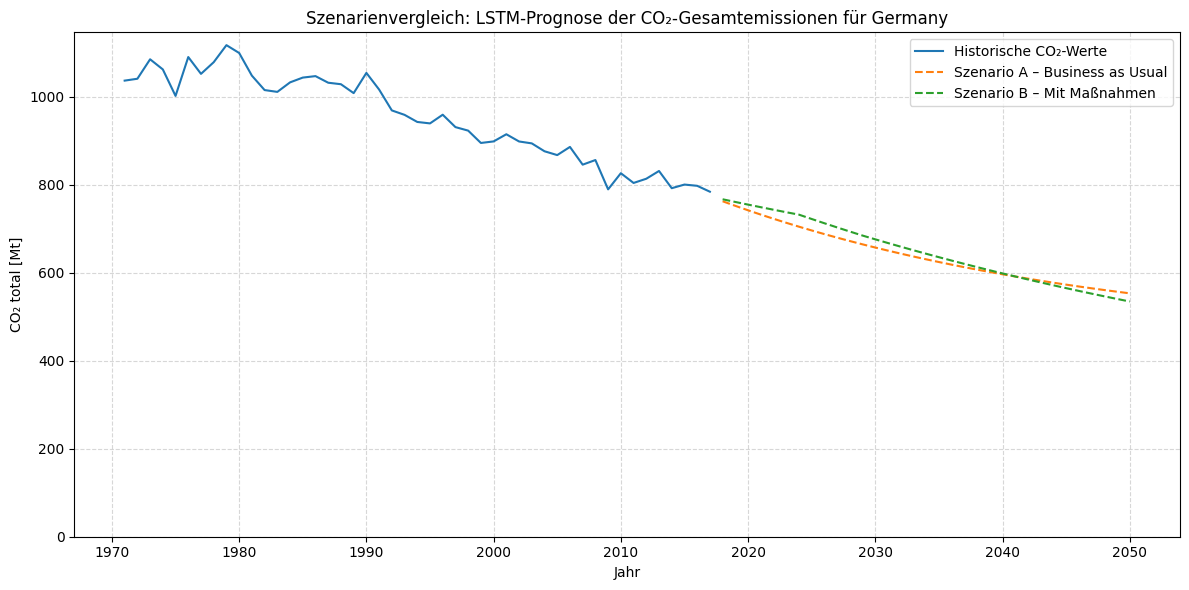

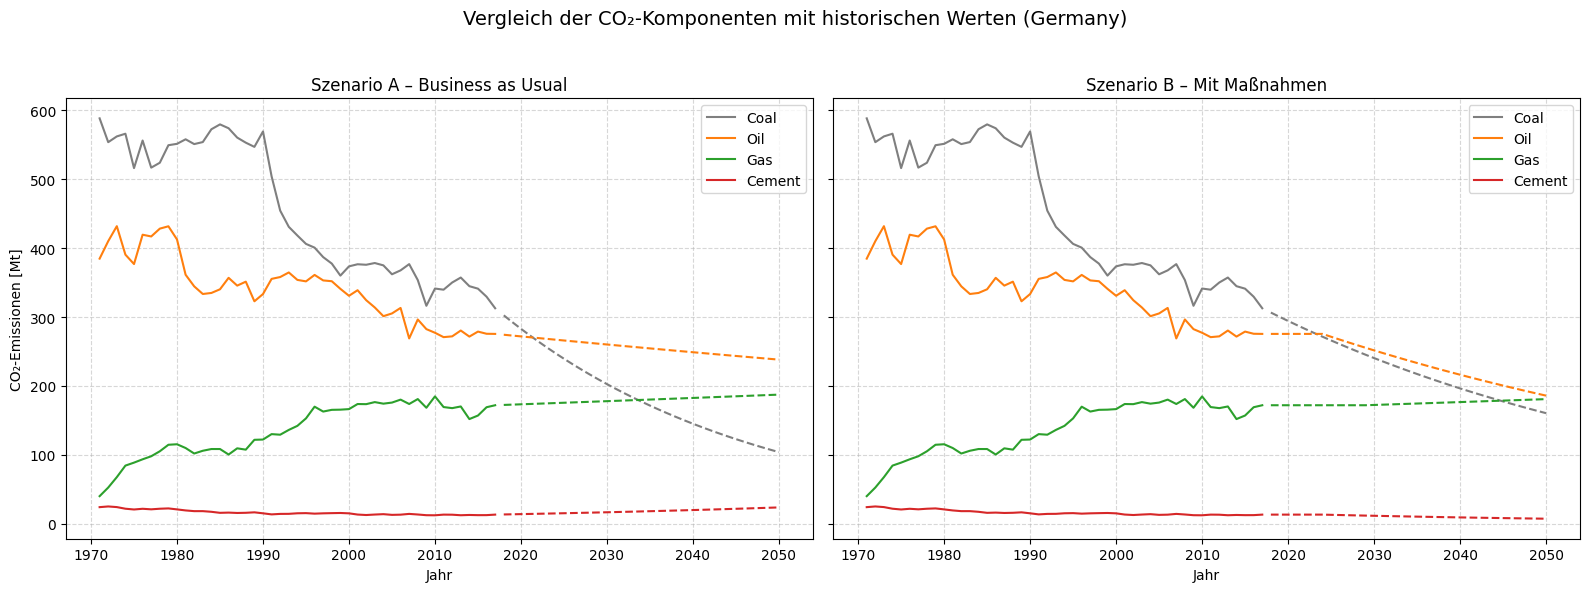

In [3]:
import os

# Zielvariablen definieren
target_columns = ['CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']

# Prognosezeitraum
future_years = list(range(2018, 2051))

# Wachstumsraten für BAU – für Germany (Durchschnitt 2013–2017)
growth = {
    'GDP': 0.0163,                 # 1.63 %
    'Population': 0.0052,          # 0.52 %
    'Primary_energy': 0.0037,      # 0.37 %
    'Energy_intensity': -0.0123,   # -1.23 %
    'CO2_coal': -0.0328,           # -3.28 %
    'CO2_oil': -0.0044,            # -0.44 %
    'CO2_gas': 0.0026,             # 0.26 %
    'CO2_cement': 0.0176,          # 1.76 %
    'Urban_population_pct': 0.0002,# 0.02 %
    'Trade_share_GDP': 0.0007,     # 0.07 %
    'GDP_growth_annual': 0.0724    # 7.24 %
}

# Letzter bekannter Datenpunkt (2017)
last_row = df_model[input_features + target_columns].iloc[-1].copy()
last_row['Year'] = 2017
last_row['CO2_total'] = last_row['CO2_coal'] + last_row['CO2_oil'] + last_row['CO2_gas'] + last_row['CO2_cement']

bau = last_row.copy()
measures = last_row.copy()

bau_rows = []
measure_rows = []

# Iteration über Zieljahre
for year in future_years:
    # BAU – normales Wachstum
    row_bau = bau.copy()
    row_bau['Year'] = year
    for key in growth:
        if key in row_bau:
            row_bau[key] *= (1 + growth[key])

    # Maßnahmen – direkte Eingriffe
    row_mea = measures.copy()
    row_mea['Year'] = year

    # Allgemeine wirtschaftliche Variablen (etwas abgeschwächt)
    row_mea['GDP'] *= 1.02
    row_mea['Population'] *= 1.006
    row_mea['Urban_population_pct'] *= 1.0226
    row_mea['Trade_share_GDP'] *= 0.9492
    row_mea['Primary_energy'] *= 0.98  # optionaler Rückgang

    # CO₂-Eingriffe
    if year >= 2018:
        row_mea['CO2_coal'] *= (1 - 0.02)  # -2 %/Jahr ab 2018

    if year >= 2025:
        row_mea['CO2_oil'] *= (1 - 0.015)  # -1.5 %/Jahr
        base_energy_intensity = row_mea['Energy_intensity'] / (1 + growth['Energy_intensity'])
        row_mea['Energy_intensity'] = base_energy_intensity * (1 - 0.06)  # -6 %/Jahr
        base_cement = row_mea['CO2_cement'] / (1 + growth['CO2_cement'])
        row_mea['CO2_cement'] = base_cement * (1 - 0.005)  # -0.5 %/Jahr

    if year >= 2030:
        base_gas = row_mea['CO2_gas'] / (1 + growth['CO2_gas'])
        row_mea['CO2_gas'] = base_gas * (1 + 0.005)  # leicht +0.5 % pro Jahr

    # CO2_total jeweils berechnen
    row_bau['CO2_total'] = row_bau['CO2_coal'] + row_bau['CO2_oil'] + row_bau['CO2_gas'] + row_bau['CO2_cement']
    row_mea['CO2_total'] = row_mea['CO2_coal'] + row_mea['CO2_oil'] + row_mea['CO2_gas'] + row_mea['CO2_cement']

    # Speichern
    bau_rows.append(row_bau.copy())
    measure_rows.append(row_mea.copy())

    # Update für nächste Iteration
    bau = row_bau.copy()
    measures = row_mea.copy()

# DataFrames erzeugen
df_bau_direct = pd.DataFrame(bau_rows)
df_mea_direct = pd.DataFrame(measure_rows)

# Vorschau
print("\nSzenario A – Business as Usual (direkte Entwicklung):")
df_bau_direct['Year'] = df_bau_direct['Year'].astype(int)
print(df_bau_direct[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].to_string(index=False))

print("\nSzenario B – Mit Maßnahmen (direkte Eingriffe):")
df_mea_direct['Year'] = df_mea_direct['Year'].astype(int)
print(df_mea_direct[['Year', 'CO2_total', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']].to_string(index=False))

# Ergebnisordner erstellen und speichern
output_folder = '../data/results/szenario_prognose_germany_lsmt/'
os.makedirs(output_folder, exist_ok=True)

df_bau_direct.to_csv(os.path.join(output_folder, 'germany_bau.csv'), index=False)
df_mea_direct.to_csv(os.path.join(output_folder, 'germany_measures.csv'), index=False)

print(f"\n Prognosedateien gespeichert in: {output_folder}")

# Plot-Stil
plt.figure(figsize=(12, 6))

# Historische Daten bis 2017
plt.plot(historical_data['Year'], historical_data['CO2_total'], label='Historische CO₂-Werte', color='tab:blue')

# Prognose – BAU
plt.plot(df_bau_direct['Year'], df_bau_direct['CO2_total'], linestyle='--', color='tab:orange', label='Szenario A – Business as Usual')

# Prognose – Maßnahmen
plt.plot(df_mea_direct['Year'], df_mea_direct['CO2_total'], linestyle='--', color='tab:green', label='Szenario B – Mit Maßnahmen')

# Titel und Achsenbeschriftungen
plt.title('Szenarienvergleich: LSTM-Prognose der CO₂-Gesamtemissionen für Germany')
plt.xlabel('Jahr')
plt.ylabel('CO₂ total [Mt]')

# Legende
plt.legend()

# Achsenbegrenzung optional
plt.ylim(bottom=0)

# Raster
plt.grid(True, linestyle='--', alpha=0.5)

# Anzeigen
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Farben pro Komponente – konsistent
colors = {
    'CO2_coal': 'tab:gray',
    'CO2_oil': 'tab:orange',
    'CO2_gas': 'tab:green',
    'CO2_cement': 'tab:red'
}

# Historische Daten extrahieren
historical_co2 = historical_data[['Year', 'CO2_coal', 'CO2_oil', 'CO2_gas', 'CO2_cement']]

# Subplots: 1 Zeile, 2 Spalten
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# 1. Plot – Business as Usual
for col in colors.keys():
    # Historische Werte
    axes[0].plot(historical_co2['Year'], historical_co2[col], linestyle='-', label=col.replace('CO2_', '').capitalize(), color=colors[col])
    # Prognose
    axes[0].plot(df_bau_direct['Year'], df_bau_direct[col], linestyle='--', color=colors[col])

axes[0].set_title('Szenario A – Business as Usual')
axes[0].set_xlabel('Jahr')
axes[0].set_ylabel('CO₂-Emissionen [Mt]')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# 2. Plot – Mit Maßnahmen
for col in colors.keys():
    # Historische Werte
    axes[1].plot(historical_co2['Year'], historical_co2[col], linestyle='-', label=col.replace('CO2_', '').capitalize(), color=colors[col])
    # Prognose
    axes[1].plot(df_mea_direct['Year'], df_mea_direct[col], linestyle='--', color=colors[col])

axes[1].set_title('Szenario B – Mit Maßnahmen')
axes[1].set_xlabel('Jahr')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

# Layout und Titel
plt.suptitle('Vergleich der CO₂-Komponenten mit historischen Werten (Germany)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()